## Logistic Regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set,generate_no_fold_set
from model.logistic import LogisticRegression
#from logistic_regression import LogisticRegression
train_loss_record = []
train_accuracy_record = []
holdout_loss_record = []
holdout_accuracy_record = []
test_accuracy_record = []
n_components = 40



In [3]:
#Q5 - (a) - added in logistic.py
def select_binarydata(dataset, class_a,class_b):
    Data, labels = dataset
    print(np.shape(Data),np.shape(labels))
    #only save class a, and class b.
    idx_class_a = np.where(labels == class_a)
    idx_class_b = np.where(labels == class_b)
    Data_class_a = Data[idx_class_a]
    Data_class_b = Data[idx_class_b]

    Data_ = np.concatenate([Data_class_a,Data_class_b])
    label_ = np.concatenate([labels[idx_class_a],labels[idx_class_b]])
    return   Data_ ,label_
    # Image : (cnt, 32x32 byte = 1024) in one img data , 1 byte in one image data


#Q5 - (b) - Evaluate the model on Speed limit 100km/h vs 120km/h using the unaligned dataset

(34799, 1024) (34799,)
[1.58247521e+04 1.08560334e+04 4.07107768e+03 3.50159973e+03
 2.60311787e+03 2.42739202e+03 2.16945532e+03 1.97751838e+03
 1.83969399e+03 1.77349869e+03 1.60488397e+03 1.52472073e+03
 1.50703007e+03 1.38522357e+03 1.27470752e+03 1.21471305e+03
 1.15107376e+03 1.12769724e+03 1.03173867e+03 1.01019804e+03
 9.38360411e+02 9.31631569e+02 8.82850681e+02 8.32797539e+02
 8.20207352e+02 7.86061909e+02 7.46532054e+02 7.12878345e+02
 6.93033391e+02 6.65684305e+02 6.47958592e+02 6.07374654e+02
 6.02754887e+02 5.78789001e+02 5.56951670e+02 5.36868273e+02
 5.24045807e+02 5.07458099e+02 4.98025016e+02 4.84522986e+02
 4.75589598e+02 4.50002792e+02 4.40912401e+02 4.26582751e+02
 4.22186776e+02 4.06604798e+02 4.02772758e+02 3.93874569e+02
 3.74962390e+02 3.67188696e+02 3.63807788e+02 3.61741290e+02
 3.44958499e+02 3.31226769e+02 3.24701399e+02 3.21477171e+02
 3.09420916e+02 3.02455769e+02 2.96143718e+02 2.84081673e+02
 2.83837279e+02 2.77349121e+02 2.73357436e+02 2.69108622e+02
 

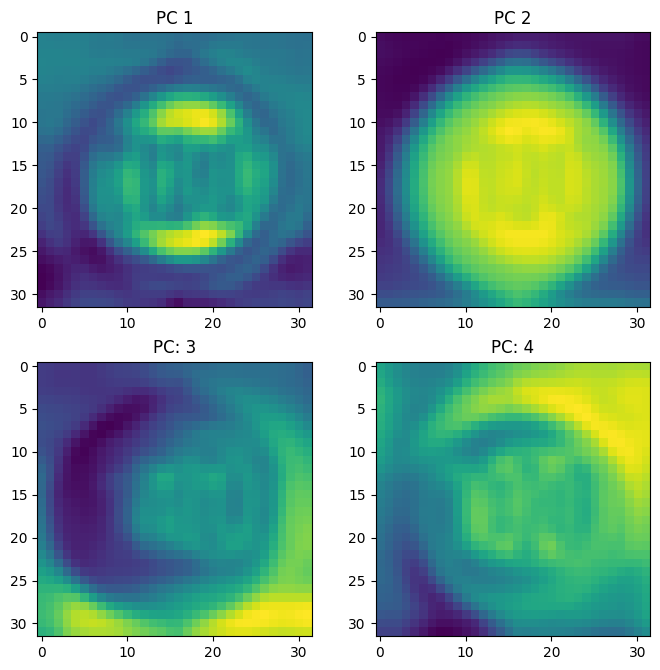

In [6]:
#unlined dataset - pca looks pretty bad.
#change data only for 100km/h(class7) and 120km/h(class8)
load_data = traffic_sign(False)
load_data_binary = select_binarydata(load_data,7,8)
#data splits 80/10/10
train_data, train_label, valid_data, valid_label, test_data, test_label = generate_k_fold_set(load_data_binary,10)
pca = PCA(train_data, n_components)
projected, mean_image, sqrt_eigen_values, eigen_vectors  = pca.PCA_Emmet()
pca.plot_PC()


In [9]:
#train 50 epochs as opposed to 300
#learning rate
Alpha = 0.01
w = np.random.rand(n_components + 1)
logistic = LogisticRegression(Alpha)
#weight
pjt_train_data = projected 
pjt_valid_data = pca.PCA_generate(valid_data)
pjt_test_data = pca.PCA_generate(test_data)

print(np.shape(train_label))
for epoch in range(3):
    #logistic model 
    train_y = logistic.logistic_model(w, pjt_train_data)
    #loss check
    train_loss = logistic.loss_binary(train_y, train_label)
    #gradient check
    train_loss_record.append(train_loss)
    train_accuracy = logistic.check_accuracy(train_y, train_label)
    train_accuracy_record.append(train_accuracy)
    #process for validation sets only checking the accuray, not updating the weight
    holdout_y = logistic.logistic_model(w,pjt_valid_data)
    holdout_loss = logistic.loss_binary(holdout_y, valid_label)
    holdout_accuracy = logistic.check_accuracy(holdout_y, valid_label)
    holdout_loss_record.append(holdout_loss)
    holdout_accuracy_record.append(holdout_accuracy)
    #evaluate best option for test sets
    '''
    if max(holdout_accuracy_record[0]) == holdout_accuracy:
        test_y = logistic.logistic_model(pjt_test_data)
        test_accuracy_record = logistic.check_accuracy(test_y, test_labels)
    '''
    #update the weight
    w = logistic.update_weight(w,pjt_train_data, train_y, train_label)
    
    
    print(f' test accuracy, train loss: {train_accuracy_record,train_loss}')
#plt.plot('loss', train_loss_record, holdout_loss_record)
#plt.plot('accuracy', train_accuracy_record, holdout_accuracy_record)

(205,)
 test accuracy, train loss: ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 202.87285483124)
 test accuracy, train loss: ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 3577.06927355747)
 test accuracy, train loss: ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 6876.136048758777)


##Q5 - (c) - Evaluate the model on Curve Left vs Right using the aligned dataset

41


In [ ]:
#Q5 - (d) - Evaluate the model on Speed limit 100km/h vs 120km/h using the aligned dataset